## Task description:

Provide product sales predictions in order to help to plan stock level.

### Datasets:

**sales.csv**- Data on product-level weekly sales:

- week_starting_date - first day of the week date in format YYYYMMDD
- product_id - unique id for product
- sales - weekly sales in pieces

**categories.csv**- Data on which categories products are assigned to:
- product_id - unique id for product
- category_id - unique id for category

**traffic.csv**:
- week_starting_date - first day of the week date in format YYYYMMDD
- product_id - unique id for product
- traffic - weekly product displays on website'''

### 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random

from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

### 2. Data Collection and preprocessing

In [2]:
# Load datasets
sales_df = pd.read_csv('data/sales.csv', delimiter=';')
categories_df = pd.read_csv('data/categories.csv', delimiter=';')
traffic_df = pd.read_csv('data/traffic.csv', delimiter=';')

# Display the first few rows of each dataframe 
sales_df.head(), categories_df.head(), traffic_df.head()

(   week_starting_date  product_id  sales
 0            20191209        1990      1
 1            20201123        1990      1
 2            20201207        1990      1
 3            20191202        1990      1
 4            20201109        1990      2,
    product_id  category_id
 0        1990            0
 1        2361            1
 2        1085            2
 3        3091            3
 4         955            4,
    week_starting_date  product_id  traffic
 0            20190107        1990        1
 1            20190107        2361        7
 2            20190107        1085        1
 3            20190107        3091        4
 4            20190107         955       12)

In [3]:
# Display the more details about the dataframes
sales_df.info(), categories_df.info(), traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105781 entries, 0 to 105780
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype
---  ------              --------------   -----
 0   week_starting_date  105781 non-null  int64
 1   product_id          105781 non-null  int64
 2   sales               105781 non-null  int64
dtypes: int64(3)
memory usage: 2.4 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3135 entries, 0 to 3134
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   product_id   3135 non-null   int64
 1   category_id  3135 non-null   int64
dtypes: int64(2)
memory usage: 49.1 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176324 entries, 0 to 176323
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype
---  ------              --------------   -----
 0   week_starting_date  176324 non-null  int64
 1   product_id          176324 non-null  int64
 2   

(None, None, None)

In [4]:
# Convert the date columns to datetime format
sales_df['week_starting_date'] = pd.to_datetime(sales_df['week_starting_date'], format='%Y%m%d')
traffic_df['week_starting_date'] = pd.to_datetime(traffic_df['week_starting_date'], format='%Y%m%d')

# Merge the datasets on product_id and week_starting_date
merged_df = pd.merge(sales_df, traffic_df, on=['week_starting_date', 'product_id'], how='outer')
merged_df = pd.merge(merged_df, categories_df, on='product_id', how='left')

# Handle missing values in the traffic and sales column by filling with 0
merged_df['traffic'].fillna(0, inplace=True)
merged_df['sales'].fillna(0, inplace=True)

In [5]:
# Display the first few rows of the merged dataframe
merged_df.head()

,week_starting_date,product_id,sales,traffic,category_id
0,2019-12-09,1990,1.0,1.0,0
1,2020-11-23,1990,1.0,0.0,0
2,2020-12-07,1990,1.0,0.0,0
3,2019-12-02,1990,1.0,1.0,0
4,2020-11-09,1990,2.0,1.0,0


### 3. Exploratory Data Analysis (EDA)

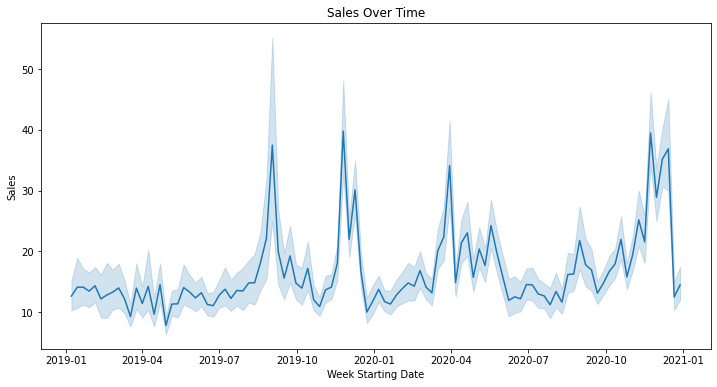

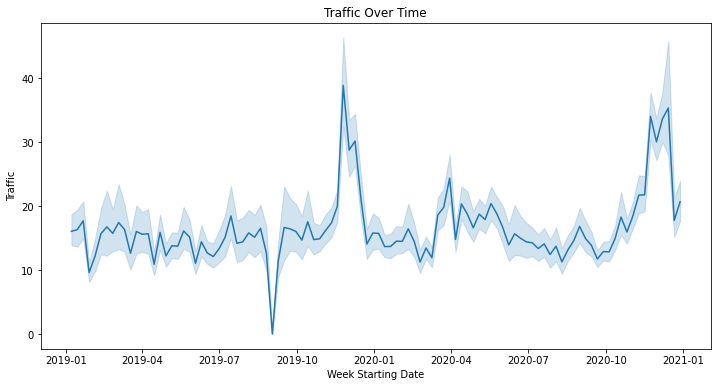

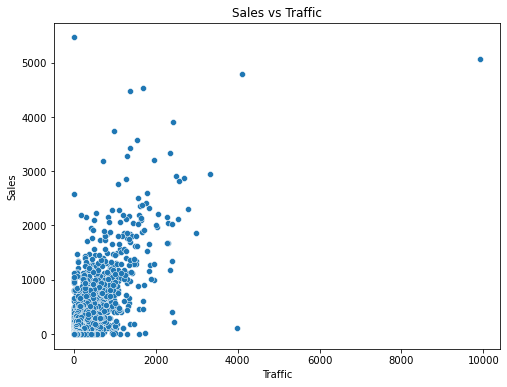

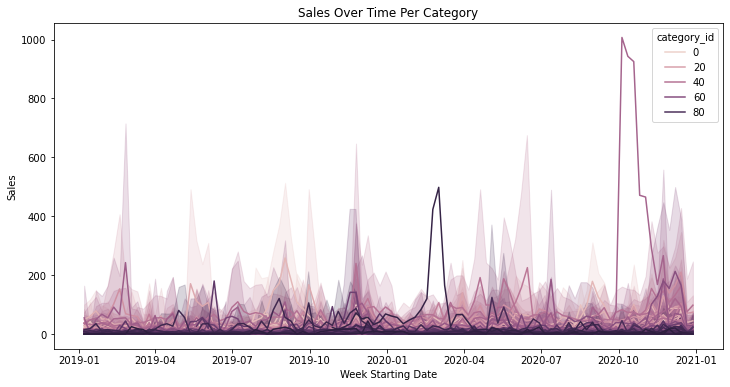

In [6]:
# Analyze distributions, trends, and correlations
# Plot sales over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=merged_df, x='week_starting_date', y='sales')
plt.title('Sales Over Time')
plt.xlabel('Week Starting Date')
plt.ylabel('Sales')
plt.show()

# Plot traffic over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=merged_df, x='week_starting_date', y='traffic')
plt.title('Traffic Over Time')
plt.xlabel('Week Starting Date')
plt.ylabel('Traffic')
plt.show()

# Scatter plot to examine correlation between sales and traffic
plt.figure(figsize=(8, 6))
sns.scatterplot(data=merged_df, x='traffic', y='sales')
plt.title('Sales vs Traffic')
plt.xlabel('Traffic')
plt.ylabel('Sales')
plt.show()

# Sales per categorie in time
plt.figure(figsize=(12, 6))
sns.lineplot(data=merged_df, x='week_starting_date', y='sales', hue='category_id')
plt.title('Sales Over Time Per Category')
plt.xlabel('Week Starting Date')
plt.ylabel('Sales')
plt.show()

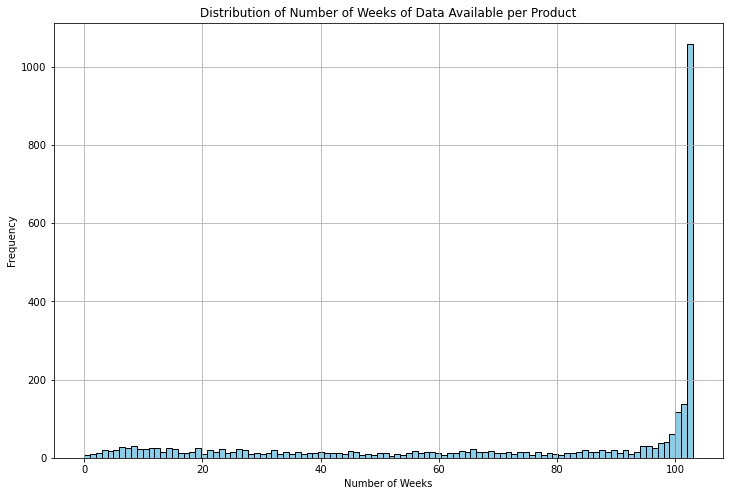

In [7]:
# Calculate the range of dates available for each product
date_range_per_product = merged_df.groupby('product_id')['week_starting_date'].agg(['min', 'max'])
date_range_per_product['duration_weeks'] = (date_range_per_product['max'] - date_range_per_product['min']).dt.days / 7

# Plot the distribution of the number of weeks of data available per product
plt.figure(figsize=(12, 8))
plt.hist(date_range_per_product['duration_weeks'], bins=104, color='skyblue', edgecolor='black')
plt.xlabel('Number of Weeks')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Weeks of Data Available per Product')
plt.grid(True)
plt.show()

**As seen in the diagram above, product data is not available for the same periods of time. In this case, we will filter and consider only the products whose difference between the first and last occurrence is equal to 2 years of data. This is associated with the model we would like to use, which is SARIMAX.**

### 4. Feature Engineering

In [8]:
# Filter date_range_per_product to get product_ids with duration_weeks > 102
filtered_product_ids = date_range_per_product[date_range_per_product['duration_weeks'] > 102].index.unique()

In [9]:
# Get 150 random values from the list - for the sake of time and memory issues
filtered_product_ids = random.sample(list(filtered_product_ids), 150)

In [10]:
# Filter merged_df to get rows with the filtered product_ids
merged_df = merged_df[merged_df['product_id'].isin(filtered_product_ids)]

In [11]:
# For some products, some of the dates between their min and max dates are missing - We are assuming that if there is no entry for date between their min and max - the value of sales or traffic is equal to 0
def fill_missing_dates(df):
    # Ensure the date column is in datetime format
    df['week_starting_date'] = pd.to_datetime(df['week_starting_date'])
    
    # Get unique product IDs
    product_ids = df['product_id'].unique()
    
    # Initialize an empty DataFrame to store results
    complete_df = pd.DataFrame()
    
    for product_id in product_ids:
        # Filter data for the current product
        product_data = df[df['product_id'] == product_id]
        
        # Get the category_id for the current product
        category_id = product_data['category_id'].iloc[0]
        
        # Get the minimum and maximum date for the product
        min_date = product_data['week_starting_date'].min()
        max_date = product_data['week_starting_date'].max()
        
        # Create a complete date range from min_date to max_date
        complete_date_range = pd.date_range(start=min_date, end=max_date, freq='W-MON')
        
        # Create a DataFrame with the complete date range
        complete_dates_df = pd.DataFrame(complete_date_range, columns=['week_starting_date'])
        complete_dates_df['product_id'] = product_id
        
        # Merge the complete date range with the existing product data
        product_complete_df = pd.merge(complete_dates_df, product_data, on=['week_starting_date', 'product_id'], how='left')
        
        # Fill missing values for sales and traffic with 0
        product_complete_df['sales'].fillna(0, inplace=True)
        product_complete_df['traffic'].fillna(0, inplace=True)
        
        # Fill missing category_id with the appropriate category
        product_complete_df['category_id'].fillna(category_id, inplace=True)
        
        # Append the result to the complete_df
        complete_df = pd.concat([complete_df, product_complete_df], ignore_index=True)
    
    return complete_df

merged_df = fill_missing_dates(merged_df)

In [12]:
# setting date as a index
merged_df.set_index(merged_df['week_starting_date'], inplace=True, drop=True)
merged_df.sort_index(inplace=True)
merged_df.head()

,week_starting_date,product_id,sales,traffic,category_id
week_starting_date,,,,,
2019-01-07,2019-01-07,2440,0.0,5.0,35.0
2019-01-07,2019-01-07,703,5.0,5.0,17.0
2019-01-07,2019-01-07,2782,0.0,2.0,51.0
2019-01-07,2019-01-07,2987,13.0,5.0,5.0
2019-01-07,2019-01-07,1347,0.0,1.0,83.0


In [13]:
def decompose_time_series(df, product_id):
    product_data = df[df['product_id'] == product_id]
    
    # Decompose the time series
    decomposition = seasonal_decompose(product_data['sales'], model='additive', period=52, extrapolate_trend='freq')
    
    # Extract components
    product_data.loc[:, 'trend'] = decomposition.trend
    product_data.loc[:, 'seasonal'] = decomposition.seasonal
    product_data.loc[:, 'residual'] = decomposition.resid
    
    return product_data.dropna()

In [14]:
def create_features(df, product_id):
    product_data = df[df['product_id'] == product_id].copy()
    
    product_data = decompose_time_series(product_data, product_id)
    
    # Create lag features for sales, traffic, and decomposed components
    for lag in range(1, 4):
        product_data[f'sales_lag_{lag}'] = product_data['sales'].shift(lag)
        product_data[f'traffic_lag_{lag}'] = product_data['traffic'].shift(lag)
        product_data[f'trend_lag_{lag}'] = product_data['trend'].shift(lag)
        product_data[f'seasonal_lag_{lag}'] = product_data['seasonal'].shift(lag)
        product_data[f'residual_lag_{lag}'] = product_data['residual'].shift(lag)
    
    # Create rolling statistics for sales, traffic, and decomposed components
    product_data['sales_roll_mean_3'] = product_data['sales'].rolling(window=3).mean()
    product_data['sales_roll_std_3'] = product_data['sales'].rolling(window=3).std()
    product_data['traffic_roll_mean_3'] = product_data['traffic'].rolling(window=3).mean()
    product_data['traffic_roll_std_3'] = product_data['traffic'].rolling(window=3).std()
    product_data['trend_roll_mean_3'] = product_data['trend'].rolling(window=3).mean()
    product_data['trend_roll_std_3'] = product_data['trend'].rolling(window=3).std()
    product_data['seasonal_roll_mean_3'] = product_data['seasonal'].rolling(window=3).mean()
    product_data['seasonal_roll_std_3'] = product_data['seasonal'].rolling(window=3).std()
    product_data['residual_roll_mean_3'] = product_data['residual'].rolling(window=3).mean()
    product_data['residual_roll_std_3'] = product_data['residual'].rolling(window=3).std()
    
    # Extract date features
    product_data['day_of_week'] = product_data.index.dayofweek
    product_data['week_of_year'] = product_data.index.isocalendar().week
    product_data['month'] = product_data.index.month
    
    # Create target variables for 1, 2, and 3 weeks ahead forecasts
    product_data['sales_1_week_ahead'] = product_data['sales'].shift(-1)
    product_data['sales_2_weeks_ahead'] = product_data['sales'].shift(-2)
    product_data['sales_3_weeks_ahead'] = product_data['sales'].shift(-3)
    
    # Drop NaN values created by lagging, rolling, and shifting
    product_data = product_data.dropna()
    
    return product_data

In [15]:
def calculate_wape(y_true, y_pred):
    if sum(y_true)==0:
        return 0
    else:
        return sum(abs(y_true - y_pred)) / sum(y_true)

In [16]:
# Get unique product IDs
product_ids = merged_df['product_id'].unique()

# Initialize a dictionary to store the results for each product
all_products_data = {}

# Iterate over each product and create features
for product_id in product_ids:
    product_features = create_features(merged_df, product_id)
    all_products_data[product_id] = product_features

### 5.0 Base model training

In [17]:
# Prepare data for baseline model
merged_df_base = merged_df.reset_index(drop=True).sort_values(by=['product_id', 'week_starting_date'])
merged_df_base['last_week_sales'] = merged_df_base.groupby('product_id')['sales'].shift(1)

In [18]:
# Drop the first week of each product where last_week_sales is NaN
merged_df_base = merged_df_base.dropna(subset=['last_week_sales'])

In [19]:
# Initialize a dictionary to store evaluation metrics
baseline_evaluation_metrics = {}

# Evaluate the baseline model for each product
product_ids = merged_df_base['product_id'].unique()

for product_id in product_ids:
    product_data = merged_df_base[merged_df_base['product_id'] == product_id]
    
    # Define the actual and predicted values
    y_true = product_data['sales']
    y_pred = product_data['last_week_sales']
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    wape = calculate_wape(y_true, y_pred)
    
    # Store the evaluation metrics
    baseline_evaluation_metrics[product_id] = {
        '1_week_mae': mae,
        '1_week_mse': mse,
        '1_week_wape': wape
    }

In [20]:
# Convert the evaluation metrics dictionary to a DataFrame
evaluation_df_base = pd.DataFrame(baseline_evaluation_metrics).T

# Display the evaluation DataFrame
evaluation_df_base

,1_week_mae,1_week_mse,1_week_wape
39,5.747573,77.456311,1.376744
45,29.941748,3150.097087,0.477399
49,7.689320,184.524272,0.918794
50,14.941748,588.669903,0.880939
61,1.398058,4.058252,1.058824
...,...,...,...
3022,7.436893,148.796117,1.165906
3030,7.058252,114.242718,0.911028
3033,2.553398,47.466019,2.054688
3114,0.621359,1.689320,1.254902


In [21]:
# Calculate aggregate metrics (mean, std) for each evaluation metric
aggregate_metrics_base = evaluation_df_base.agg(['mean', 'std'])

# Display the aggregate metrics
aggregate_metrics_base

,1_week_mae,1_week_mse,1_week_wape
mean,10.095146,2151.130874,1.075664
std,19.782698,12909.297622,0.304327


### 5.1 RandomForestRegressor

In [22]:
# Initialize a dictionary to store models and evaluation metrics
models_rf = {}
evaluation_metrics_rf = {}

# Train and evaluate models for each product
for product_id, product_data in all_products_data.items():
    # Split the data into training and test sets based on the last 3 weeks
    train_data = product_data.iloc[:-3]
    test_data = product_data.iloc[-3:]
    
    # Prepare the final features and target variables
    features = train_data.drop(columns=['week_starting_date', 'product_id','category_id', 'sales', 'sales_1_week_ahead', 'sales_2_weeks_ahead', 'sales_3_weeks_ahead'])
    target_1_week = train_data['sales_1_week_ahead']
    target_2_weeks = train_data['sales_2_weeks_ahead']
    target_3_weeks = train_data['sales_3_weeks_ahead']
    
    test_features = test_data.drop(columns=['week_starting_date', 'product_id','category_id', 'sales', 'sales_1_week_ahead', 'sales_2_weeks_ahead', 'sales_3_weeks_ahead'])
    test_target_1_week = test_data['sales_1_week_ahead']
    test_target_2_weeks = test_data['sales_2_weeks_ahead']
    test_target_3_weeks = test_data['sales_3_weeks_ahead']
    
    # Initialize and train models for each target
    model_1_week = RandomForestRegressor(n_estimators=100, random_state=42)
    model_1_week.fit(features, target_1_week)
    models_rf[f'{product_id}_1_week'] = model_1_week
    
    model_2_weeks = RandomForestRegressor(n_estimators=100, random_state=42)
    model_2_weeks.fit(features, target_2_weeks)
    models_rf[f'{product_id}_2_weeks'] = model_2_weeks
    
    model_3_weeks = RandomForestRegressor(n_estimators=100, random_state=42)
    model_3_weeks.fit(features, target_3_weeks)
    models_rf[f'{product_id}_3_weeks'] = model_3_weeks
    
    # Predict on the test set for each model
    y_pred_1_week = model_1_week.predict(test_features)
    y_pred_2_weeks = model_2_weeks.predict(test_features)
    y_pred_3_weeks = model_3_weeks.predict(test_features)
    
    # Evaluate the models
    mae_1_week = mean_absolute_error(test_target_1_week, y_pred_1_week)
    mse_1_week = mean_squared_error(test_target_1_week, y_pred_1_week)
    wape_1_week = calculate_wape(test_target_1_week, y_pred_1_week)
    
    mae_2_weeks = mean_absolute_error(test_target_2_weeks, y_pred_2_weeks)
    mse_2_weeks = mean_squared_error(test_target_2_weeks, y_pred_2_weeks)
    wape_2_weeks = calculate_wape(test_target_2_weeks, y_pred_2_weeks)
    
    mae_3_weeks = mean_absolute_error(test_target_3_weeks, y_pred_3_weeks)
    mse_3_weeks = mean_squared_error(test_target_3_weeks, y_pred_3_weeks)
    wape_3_weeks = calculate_wape(test_target_3_weeks, y_pred_3_weeks)
    
    # Store the evaluation metrics
    evaluation_metrics_rf[product_id] = {
        '1_week_mae': mae_1_week,
        '1_week_mse': mse_1_week,
        '1_week_wape': wape_1_week,
        '2_weeks_mae': mae_2_weeks,
        '2_weeks_mse': mse_2_weeks,
        '2_weeks_wape': wape_2_weeks,
        '3_weeks_mae': mae_3_weeks,
        '3_weeks_mse': mse_3_weeks,
        '3_weeks_wape': wape_3_weeks
    }

In [23]:
# Convert the evaluation metrics dictionary to a DataFrame
evaluation_df_rf = pd.DataFrame(evaluation_metrics_rf).T

# Display the evaluation DataFrame
evaluation_df_rf

,1_week_mae,1_week_mse,1_week_wape,2_weeks_mae,2_weeks_mse,2_weeks_wape,3_weeks_mae,3_weeks_mse,3_weeks_wape
2440,22.020000,500.448600,2.446667,9.390000,122.052967,0.512182,13.283333,177.541967,0.737963
703,3.476667,25.628967,0.869167,5.870000,35.012700,8.805000,4.163333,17.448033,0.000000
2782,2.403333,6.367633,0.000000,6.316667,39.919100,0.000000,2.930000,9.745167,0.000000
2987,7.783333,100.202233,0.251075,10.900000,198.650067,0.488060,14.563333,212.734567,1.248286
1347,5.086667,36.875000,1.017333,4.200000,20.432067,4.200000,5.213333,28.139667,0.000000
...,...,...,...,...,...,...,...,...,...
769,11.323333,157.530500,0.306036,18.133333,438.044467,0.766197,31.056667,1082.430567,3.726800
665,24.663333,815.075633,0.591920,21.016667,656.926300,0.529832,7.276667,56.019300,0.225052
2405,10.836667,224.960967,1.121034,8.996667,201.272833,0.930690,16.136667,262.879633,16.136667
1115,1.123333,1.538567,1.685000,1.263333,2.412033,0.541429,2.093333,4.548733,1.256000


In [24]:
# Calculate aggregate metrics (mean, std) for each evaluation metric
aggregate_metrics_rf = evaluation_df_rf.agg(['mean', 'std'])

# Display the aggregate metrics
aggregate_metrics_rf

,1_week_mae,1_week_mse,1_week_wape,2_weeks_mae,2_weeks_mse,2_weeks_wape,3_weeks_mae,3_weeks_mse,3_weeks_wape
mean,19.544089,2209.969831,0.709090,18.954022,1798.258219,1.201533,19.538422,2264.842970,1.801202
std,40.107616,13076.294460,1.065559,35.089126,8882.585065,2.497789,38.539870,14452.540717,5.436097


### 5.2 SARIMAX

In [25]:
# Ignore specific warnings
warnings.filterwarnings("ignore", message="Too few observations to estimate starting parameters")

In [26]:
# Initialize a dictionary to store models and evaluation metrics
models_sx = {}
evaluation_metrics_sx = {}

# Train and evaluate SARIMAX models for each product
for product_id, product_data in all_products_data.items():
    # Split the data into training and test sets based on the last 3 weeks
    train_data = product_data.iloc[:-3]
    test_data = product_data.iloc[-3:]
    
    # Prepare the features and target variables
    feature_columns = ['traffic',
                       'sales_roll_mean_3', 'sales_roll_std_3', 
                       'traffic_roll_mean_3', 'traffic_roll_std_3']
    
    
    X_train = train_data[feature_columns]
    X_test = test_data[feature_columns]
    y_train = train_data['sales']
    y_test_1_week = test_data['sales'].iloc[:1]
    y_test_2_weeks = test_data['sales'].iloc[1:2]
    y_test_3_weeks = test_data['sales'].iloc[2:3]
    
    # Apply normalization to the exogenous features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Convert DataFrame to numpy array for SARIMAX compatibility
    X_train_np = np.array(X_train, dtype=float)
    X_test_np = np.array(X_test, dtype=float)
    y_train_np = np.array(y_train, dtype=float)
    y_test_1_week_np = np.array(y_test_1_week, dtype=float)
    y_test_2_weeks_np = np.array(y_test_2_weeks, dtype=float)
    y_test_3_weeks_np = np.array(y_test_3_weeks, dtype=float)
    
    
    # Train the SARIMAX model
    model = SARIMAX(endog=y_train_np, exog=X_train_np, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52), enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    models_sx[product_id] = model_fit
      
    
    # Predict on the test set for 1, 2, and 3 weeks ahead
    y_pred_1_week = model_fit.forecast(steps=1, exog=X_test_np[:1, :])[0]
    y_pred_2_weeks = model_fit.forecast(steps=2, exog=X_test_np[:2, :])[-1]
    y_pred_3_weeks = model_fit.forecast(steps=3, exog=X_test_np[:3, :])[-1]
    
    # Calculate evaluation metrics for each week ahead
    mae_1_week = mean_absolute_error(y_test_1_week_np, [y_pred_1_week])
    mse_1_week = mean_squared_error(y_test_1_week_np, [y_pred_1_week])
    wape_1_week = calculate_wape(y_test_1_week_np, [y_pred_1_week])
    
    mae_2_weeks = mean_absolute_error(y_test_2_weeks_np, [y_pred_2_weeks])
    mse_2_weeks = mean_squared_error(y_test_2_weeks_np, [y_pred_2_weeks])
    wape_2_weeks = calculate_wape(y_test_2_weeks_np, [y_pred_2_weeks])
    
    mae_3_weeks = mean_absolute_error(y_test_3_weeks_np, [y_pred_3_weeks])
    mse_3_weeks = mean_squared_error(y_test_3_weeks_np, [y_pred_3_weeks])
    wape_3_weeks = calculate_wape(y_test_3_weeks_np, [y_pred_3_weeks])
    
    # Store the evaluation metrics
    evaluation_metrics_sx[product_id] = {
        '1_week_mae': mae_1_week,
        '1_week_mse': mse_1_week,
        '1_week_wape': wape_1_week,
        '2_weeks_mae': mae_2_weeks,
        '2_weeks_mse': mse_2_weeks,
        '2_weeks_wape': wape_2_weeks,
        '3_weeks_mae': mae_3_weeks,
        '3_weeks_mse': mse_3_weeks,
        '3_weeks_wape': wape_3_weeks
    }
    

In [27]:
# Convert the evaluation metrics dictionary to a DataFrame
evaluation_df_sx = pd.DataFrame(evaluation_metrics_sx).T

# Display the evaluation DataFrame
evaluation_df_sx

,1_week_mae,1_week_mse,1_week_wape,2_weeks_mae,2_weeks_mse,2_weeks_wape,3_weeks_mae,3_weeks_mse,3_weeks_wape
2440,8.673679,75.232712,0.234424,24.166098,584.000285,3.452300,3.906930,15.264104,0.300533
703,1.999498,3.997991,0.999749,4.953218,24.534364,0.495322,5.670913,32.159254,2.835457
2782,9.589167,91.952117,0.000000,7.708752,59.424861,0.000000,10.850910,117.742246,0.000000
2987,0.515503,0.265744,0.036822,22.072410,487.191273,0.788300,28.592813,817.548968,0.840965
1347,2.020881,4.083959,0.000000,7.999623,63.993966,0.666635,0.822851,0.677083,0.274284
...,...,...,...,...,...,...,...,...,...
769,24.197462,585.517148,0.537721,24.317539,591.342709,0.607938,14.681762,215.554141,0.319169
665,6.635268,44.026780,0.189579,4.651798,21.639228,0.211445,2.785830,7.760850,0.048874
2405,2.391896,5.721169,0.000000,1.697550,2.881675,0.565850,28.915135,836.085024,1.112121
1115,3.364936,11.322798,1.682468,1.256950,1.579922,0.000000,2.439543,5.951368,1.219771


In [28]:
# Calculate aggregate metrics (mean, std) for each evaluation metric
aggregate_metrics_sx = evaluation_df_sx.agg(['mean', 'std'])

# Display the aggregate metrics
aggregate_metrics_sx

,1_week_mae,1_week_mse,1_week_wape,2_weeks_mae,2_weeks_mse,2_weeks_wape,3_weeks_mae,3_weeks_mse,3_weeks_wape
mean,17.902006,1779.863217,0.664676,22.299784,2925.784623,0.691635,21.050620,1727.623053,0.748337
std,38.329830,10664.923084,1.894250,49.444949,18746.343253,1.156647,35.959911,7849.805868,1.240105


### 6. Results

In [29]:
# Creating DataFrames with aggregated data
metrics_1_week_df = pd.DataFrame({
    'Model': ['Base', 'RandomForest', 'SARIMAX'],
    'MAE': [aggregate_metrics_base['1_week_mae'][0], aggregate_metrics_rf['1_week_mae'][0], aggregate_metrics_sx['1_week_mae'][0]],
    'MSE': [aggregate_metrics_base['1_week_mse'][0], aggregate_metrics_rf['1_week_mse'][0], aggregate_metrics_sx['1_week_mse'][0]],
    'WAPE': [aggregate_metrics_base['1_week_wape'][0], aggregate_metrics_rf['1_week_wape'][0], aggregate_metrics_sx['1_week_wape'][0]]
})

metrics_2_weeks_df = pd.DataFrame({
    'Model': ['RandomForest', 'SARIMAX'],
    'MAE': [aggregate_metrics_rf['2_weeks_mae'][0], aggregate_metrics_sx['2_weeks_mae'][0]],
    'MSE': [aggregate_metrics_rf['2_weeks_mse'][0], aggregate_metrics_sx['2_weeks_mse'][0]],
    'WAPE': [aggregate_metrics_rf['2_weeks_wape'][0], aggregate_metrics_sx['2_weeks_wape'][0]]
})

metrics_3_weeks_df = pd.DataFrame({
    'Model': ['RandomForest', 'SARIMAX'],
    'MAE': [aggregate_metrics_rf['3_weeks_mae'][0], aggregate_metrics_sx['3_weeks_mae'][0]],
    'MSE': [aggregate_metrics_rf['3_weeks_mse'][0], aggregate_metrics_sx['3_weeks_mse'][0]],
    'WAPE': [aggregate_metrics_rf['3_weeks_wape'][0], aggregate_metrics_sx['3_weeks_wape'][0]]
})

# Combining data into a single table
metrics_all_df = pd.concat([
    metrics_1_week_df.assign(Week='1 Week'),
    metrics_2_weeks_df.assign(Week='2 Weeks'),
    metrics_3_weeks_df.assign(Week='3 Weeks')
])

metrics_all_df['Model'] = metrics_all_df['Model'].replace({'RandomForest': 'RandomForestRegressor'})

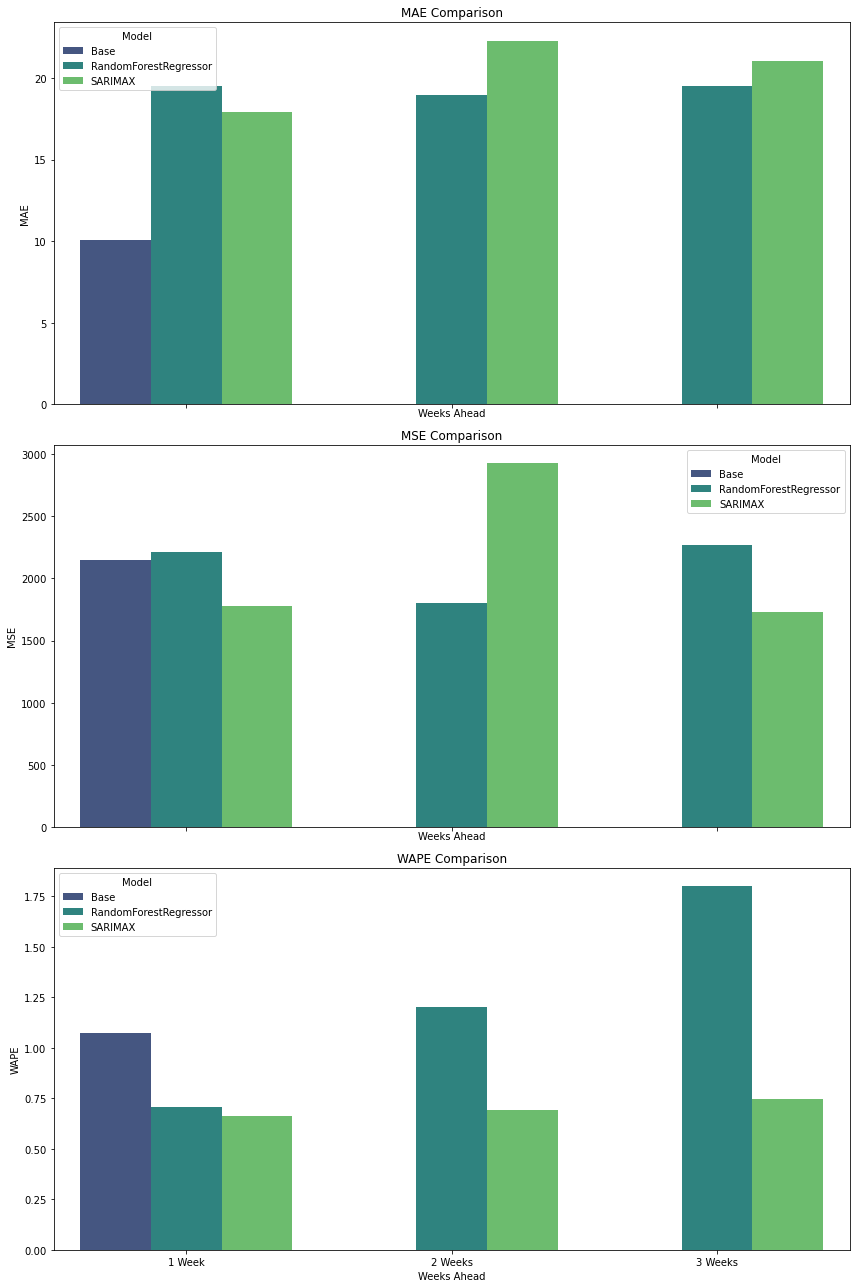

In [30]:
# Creating bar plots for MAE, MSE, and WAPE
fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

metrics = ['MAE', 'MSE', 'WAPE']

for i, metric in enumerate(metrics):
    sns.barplot(x='Week', y=metric, hue='Model', data=metrics_all_df, ax=axes[i], palette='viridis')
    axes[i].set_title(f'{metric} Comparison')
    axes[i].set_xlabel('Weeks Ahead')
    axes[i].set_ylabel(metric)
    axes[i].legend(title='Model')

plt.tight_layout()
plt.show()

### 7. Summary of Results:

The RandomForestRegressor and SARIMAX models achieved better results compared to the baseline model.
SARIMAX, although complex, showed lower average forecast errors for most products compared to RandomForestRegressor, especially for 3-week forecasts.

### 8. Conclusions:

Advanced models (RandomForest and SARIMAX) are more effective in sales forecasting than simple baseline approaches.
SARIMAX proved to be the best model for long-term forecasts, despite requiring more complex data preparation and modeling.

### 9. Limitations

1. Models have been trained for products that had a duration of 104 weeks between their first and last occurrences.
2. Out of these models, 150 products were randomly selected (due to time and machine computational capabilities) - this likely influenced the results, especially in the RandomForestRegressor.
3. Nonetheless:
   1. For sales predictions of products that had a duration of 104 weeks between their first and last occurrences, I would use a solution based on SARIMAX.
   2. For sales predictions of other products, I would use the baseline model.